## #Importing the Necessary modules and libraries

In [1]:
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

## #Reading the csv file

In [5]:
data=pd.read_csv('/kaggle/input/bakery-data/bakeryy.csv')
data.head()

,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam


In [6]:
data.shape

(20507, 4)

The dataset, its shape and statistics is checked. We find out that there are 4 columns and 20507 rows.



In [7]:
data.describe()

,Transaction
count,20507.000000
mean,4976.202370
std,2796.203001
min,1.000000
25%,2552.000000
50%,5137.000000
75%,7357.000000
max,9684.000000


In [8]:
data.shape

(20507, 4)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20507 entries, 0 to 20506
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         20507 non-null  object
 1   Time         20507 non-null  object
 2   Transaction  20507 non-null  int64 
 3   Item         20507 non-null  object
dtypes: int64(1), object(3)
memory usage: 641.0+ KB


In [10]:
data.loc[data['Item']=='NONE',:].count()

Date           0
Time           0
Transaction    0
Item           0
dtype: int64

No fields marked as 'NONE' were found in the dataset

In [11]:
data['Item'].nunique()

94

In [12]:
data['Item'].value_counts().sort_values(ascending=False).head(10)

Item
Coffee           5471
Bread            3325
Tea              1435
Cake             1025
Pastry            856
Sandwich          771
Medialuna         616
Hot chocolate     590
Cookies           540
Brownie           379
Name: count, dtype: int64

Text(0.5, 1.0, 'Best sellers')

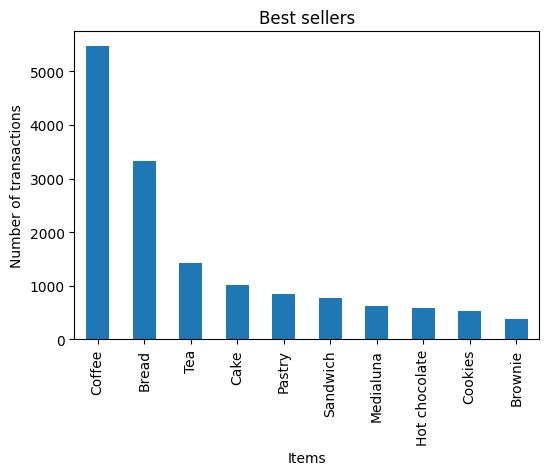

In [13]:
fig, ax=plt.subplots(figsize=(6,4))
data['Item'].value_counts().sort_values(ascending=False).head(10).plot(kind='bar')
plt.ylabel('Number of transactions')
plt.xlabel('Items')
ax.get_yaxis().get_major_formatter().set_scientific(False)
plt.title('Best sellers')

We discovered the number of items this bakery offers. It appears that the menu features 94 items, with Coffee being the most popular choice.

In [14]:
data.loc[(data['Time']<'12:00:00'),'Daytime']='Morning'
data.loc[(data['Time']>='12:00:00')&(data['Time']<'17:00:00'),'Daytime']='Afternoon'
data.loc[(data['Time']>='17:00:00')&(data['Time']<'21:00:00'),'Daytime']='Evening'
data.loc[(data['Time']>='21:00:00')&(data['Time']<'23:50:00'),'Daytime']='Night'

Text(0.5, 1.0, 'Business during the day')

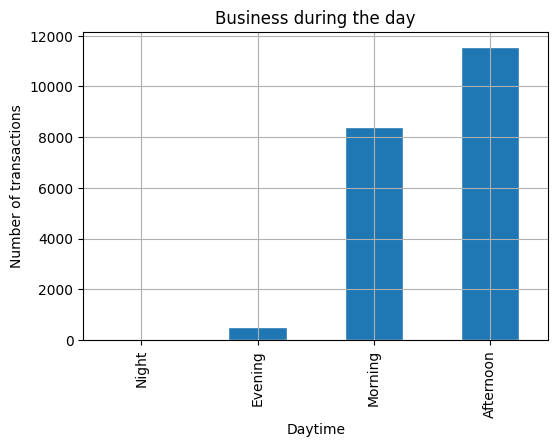

In [15]:
fig, ax=plt.subplots(figsize=(6,4))
sns.set_style('darkgrid')
data.groupby('Daytime')['Item'].count().sort_values().plot(kind='bar')
plt.ylabel('Number of transactions')
ax.get_yaxis().get_major_formatter().set_scientific(False)
plt.title('Business during the day')

The next point of interest was determining when the bakery experiences its peak business hours throughout the day. It seems that the bakery is busiest in the morning and afternoon, with much less activity during the evening and night.

In its nearly 2 years of operation, this bakery has sold over 11,569 items in the afternoon, while only 14 items were sold during the night hours.

In [16]:
data.groupby('Daytime')['Item'].count().sort_values(ascending=False)

Daytime
Afternoon    11569
Morning       8404
Evening        520
Night           14
Name: Item, dtype: int64

The month and date was extracted from the dataset for further analysis.

In [17]:
data['Date_Time']=pd.to_datetime(data['Date']+' '+data['Time'])
data['Day']=data['Date_Time'].dt.day_name()
data['Month']=data['Date_Time'].dt.month
data['Month_name']=data['Date_Time'].dt.month_name()
data['Year']=data['Date_Time'].dt.year
data['Year_Month']=data['Year'].apply(str)+' '+data['Month_name'].apply(str)
data.drop(['Date','Time'], axis=1, inplace=True)

data.index=data['Date_Time']
data.index.name='Date'
data.drop(['Date_Time'],axis=1,inplace=True)
data.head()

,Transaction,Item,Daytime,Day,Month,Month_name,Year,Year_Month
Date,,,,,,,,
2016-10-30 09:58:11,1,Bread,Morning,Sunday,10,October,2016,2016 October
2016-10-30 10:05:34,2,Scandinavian,Morning,Sunday,10,October,2016,2016 October
2016-10-30 10:05:34,2,Scandinavian,Morning,Sunday,10,October,2016,2016 October
2016-10-30 10:07:57,3,Hot chocolate,Morning,Sunday,10,October,2016,2016 October
2016-10-30 10:07:57,3,Jam,Morning,Sunday,10,October,2016,2016 October


Text(0.5, 1.0, 'Business during the past months')

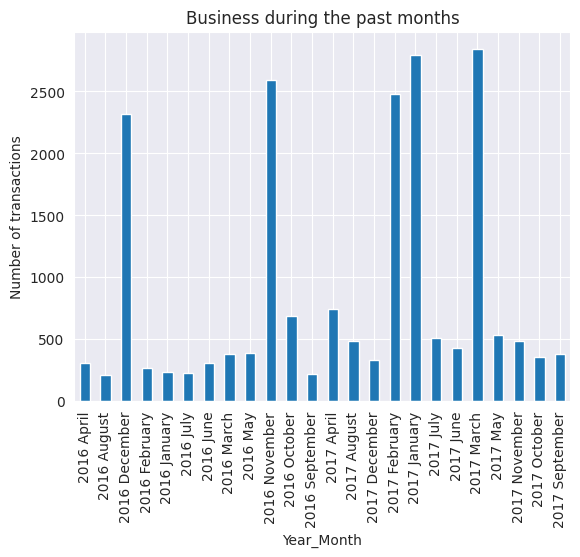

In [18]:
data.groupby('Year_Month')['Item'].count().plot(kind='bar')
plt.ylabel('Number of transactions')
plt.title('Business during the past months')

The plot shows the performance of bakery during different months of its entire existence. Winter and Fall seasons showed the most business due to the demand for cozy, comforting drinks and warm delicious snacks.


In [19]:
data.loc[data['Year_Month']=='2016 October'].nunique()

Transaction    325
Item            41
Daytime          3
Day              4
Month            1
Month_name       1
Year             1
Year_Month       1
dtype: int64

In [20]:
data.loc[data['Year_Month']=='2017 April'].nunique()

Transaction    328
Item            43
Daytime          3
Day              4
Month            1
Month_name       1
Year             1
Year_Month       1
dtype: int64

In [21]:
data2=data.pivot_table(index='Month_name',columns='Item', aggfunc={'Item':'count'}).fillna(0)
data2['Max']=data2.idxmax(axis=1)
data2

Item                                                     \
Item       Adjustment Afternoon with the baker Alfajores Argentina Night   
Month_name                                                                 
April             0.0                      0.0      15.0             0.0   
August            0.0                      3.0      19.0             4.0   
December          0.0                      2.0      33.0             0.0   
February          0.0                      8.0      83.0             1.0   
January           0.0                     10.0      50.0             0.0   
July              0.0                      1.0      14.0             0.0   
June              0.0                      2.0      25.0             0.0   
March             0.0                      8.0      23.0             1.0   
May               0.0                      6.0      16.0             0.0   
November          0.0                      3.0      73.0             1.0   
October           0.0                      1.0      10.0             0.0   
September         1.0                      0.0       8.0             0.0   

                                                                 ...  \
Item       Art Tray Bacon Baguette Bakewell Bare Popcorn Basket  ...   
Month_name                                                       ...   
April           1.0   0.0      9.0      0.0          0.0    0.0  ...   
August          3.0   0.0      7.0      0.0          0.0    0.0  ...   
December        4.0   0.0      5.0      5.0          3.0    0.0  ...   
February        3.0   0.0     35.0      0.0          2.0    0.0  ...   
January         4.0   0.0     28.0     11.0          0.0    0.0  ...   
July            0.0   0.0      6.0      0.0          0.0    0.0  ...   
June            1.0   0.0      2.0      0.0          0.0    1.0  ...   
March           2.0   0.0     43.0     19.0          0.0    0.0  ...   
May             0.0   0.0      4.0      0.0          0.0    3.0  ...   
November       16.0   1.0      5.0     13.0          0.0    0.0  ...   
October         4.0   0.0      3.0      0.0          0.0    2.0  ...   
September       0.0   0.0      5.0      0.0          0.0    0.0  ...   

                                                                    \
Item       The Nomad Tiffin Toast Truffles Tshirt Valentine's card   
Month_name                                                           
April            2.0    4.0  13.0     14.0   21.0              5.0   
August           8.0    7.0   4.0     11.0    0.0              0.0   
December         8.0    3.0  52.0     24.0    0.0              0.0   
February         7.0   28.0  44.0     19.0    0.0              3.0   
January         14.0   28.0  58.0     28.0    0.0              1.0   
July             0.0    7.0  14.0     10.0    0.0              0.0   
June             0.0    6.0  19.0      6.0    0.0              0.0   
March            6.0   36.0  66.0     35.0    0.0              0.0   
May              1.0    8.0  12.0      8.0    0.0              0.0   
November         8.0   11.0  14.0     22.0    0.0              1.0   
October          1.0    6.0   8.0     12.0    0.0              1.0   
September        3.0    2.0  14.0      4.0    0.0              2.0   

                                                                   Max  
Item       Vegan Feast Vegan mincepie Victorian Sponge                  
Month_name                                                              
April              2.0            0.0              0.0  (Item, Coffee)  
August             7.0            3.0              0.0  (Item, Coffee)  
December           1.0           31.0              0.0  (Item, Coffee)  
February           2.0            4.0              0.0  (Item, Coffee)  
January            0.0            7.0              1.0  (Item, Coffee)  
July               0.0            0.0              0.0  (Item, Coffee)  
June               0.0            0.0              1.0  (Item, Coffee)  
March         

Here, I wanted to identify the monthly bestseller. The table below displays nthe item with the highest number of buyers as well as the quantities sold for each item of interest. As anticipated earlier, coffee emerges as the top seller in every month.

In [22]:
data3=data.pivot_table(index='Daytime',columns='Item', aggfunc={'Item':'count'}).fillna(0)
data3['Max']=data3.idxmax(axis=1)
data3

Item                                                     \
Item      Adjustment Afternoon with the baker Alfajores Argentina Night   
Daytime                                                                   
Afternoon        0.0                     19.0     245.0             3.0   
Evening          1.0                     15.0      17.0             0.0   
Morning          0.0                     10.0     107.0             4.0   
Night            0.0                      0.0       0.0             0.0   

                                                                ...            \
Item      Art Tray Bacon Baguette Bakewell Bare Popcorn Basket  ... The Nomad   
Daytime                                                         ...             
Afternoon     31.0   1.0     67.0     30.0          4.0    0.0  ...      31.0   
Evening        2.0   0.0      1.0      0.0          1.0    0.0  ...       1.0   
Morning        5.0   0.0     84.0     18.0          0.0    6.0  ...      26.0   
Night          0.0   0.0      0.0      0.0          0.0    0.0  ...       0.0   

                                                                      \
Item      Tiffin  Toast Truffles Tshirt Valentine's card Vegan Feast   
Daytime                                                                
Afternoon   93.0  114.0    152.0    0.0              4.0         4.0   
Evening      4.0    0.0      7.0   21.0              4.0         3.0   
Morning     49.0  204.0     34.0    0.0              3.0         2.0   
Night        0.0    0.0      0.0    0.0              2.0         7.0   

                                                           Max  
Item      Vegan mincepie Victorian Sponge                       
Daytime                                                         
Afternoon           30.0              5.0       (Item, Coffee)  
Evening              2.0              0.0       (Item, Coffee)  
Morning             22.0              2.0       (Item, Coffee)  
Night                0.0              0.0  (Item, Vegan Feast)  

[4 rows x 95 columns]

Here, I tried to find out the bestseller during the day. Coffee leads the charts in the morning, afternoon, and evening, but understandably, it isn't as popular at night. Instead, Vegan Feast emerges as the top seller during nighttime.

In [23]:
data4=data.pivot_table(index='Day',columns='Item', aggfunc={'Item':'count'}).fillna(0)
data4['Max']=data4.idxmax(axis=1)
data4

Item                                                     \
Item      Adjustment Afternoon with the baker Alfajores Argentina Night   
Day                                                                       
Friday           0.0                      6.0      58.0             5.0   
Monday           0.0                      5.0      44.0             0.0   
Saturday         0.0                     12.0      60.0             1.0   
Sunday           1.0                      5.0      69.0             0.0   
Thursday         0.0                      5.0      61.0             1.0   
Tuesday          0.0                      3.0      47.0             0.0   
Wednesday        0.0                      8.0      30.0             0.0   

                                                                ...            \
Item      Art Tray Bacon Baguette Bakewell Bare Popcorn Basket  ... The Nomad   
Day                                                             ...             
Friday         4.0   0.0     24.0      3.0          0.0    0.0  ...      10.0   
Monday         3.0   0.0     21.0      9.0          0.0    0.0  ...       7.0   
Saturday       1.0   0.0     19.0     11.0          0.0    1.0  ...      11.0   
Sunday         8.0   1.0     23.0      8.0          0.0    2.0  ...      11.0   
Thursday       8.0   0.0     25.0      3.0          4.0    0.0  ...       5.0   
Tuesday        6.0   0.0     25.0     13.0          0.0    0.0  ...       7.0   
Wednesday      8.0   0.0     15.0      1.0          1.0    3.0  ...       7.0   

                                                                     \
Item      Tiffin Toast Truffles Tshirt Valentine's card Vegan Feast   
Day                                                                   
Friday      32.0  58.0     32.0    0.0              0.0         8.0   
Monday       9.0  42.0     35.0    0.0              1.0         1.0   
Saturday    29.0  52.0     21.0    0.0              3.0         0.0   
Sunday      25.0  35.0     32.0   21.0              5.0         3.0   
Thursday    21.0  52.0     20.0    0.0              2.0         0.0   
Tuesday     17.0  48.0     35.0    0.0              2.0         3.0   
Wednesday   13.0  31.0     18.0    0.0              0.0         1.0   

                                                      Max  
Item      Vegan mincepie Victorian Sponge                  
Day                                                        
Friday              10.0              0.0  (Item, Coffee)  
Monday               7.0              1.0  (Item, Coffee)  
Saturday            10.0              1.0  (Item, Coffee)  
Sunday               6.0              3.0  (Item, Coffee)  
Thursday             4.0              0.0  (Item, Coffee)  
Tuesday              8.0              0.0  (Item, Coffee)  
Wednesday            9.0              2.0  (Item, Coffee)  

[7 rows x 95 columns]

As anticipated, Coffee is the best seller from Monday to Sunday.

Text(0.5, 1.0, 'Business during the past months')

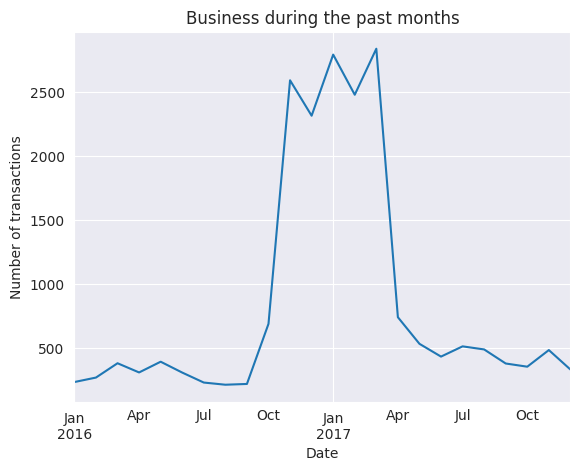

In [24]:
data['Item'].resample('M').count().plot()
plt.ylabel('Number of transactions')
plt.title('Business during the past months')

I was interested in analyzing the bakery's business growth, so I created several line plots. As seen in the bar chart, April experienced the highest sales for the bakery, with winter months following closely. There was a noticeable decline after summer began. The bakery likely opened in January 2016, so sales were initially low as it was just starting out but then peaked during the winter months.

Text(0.5, 1.0, 'Weekly business during the past months')

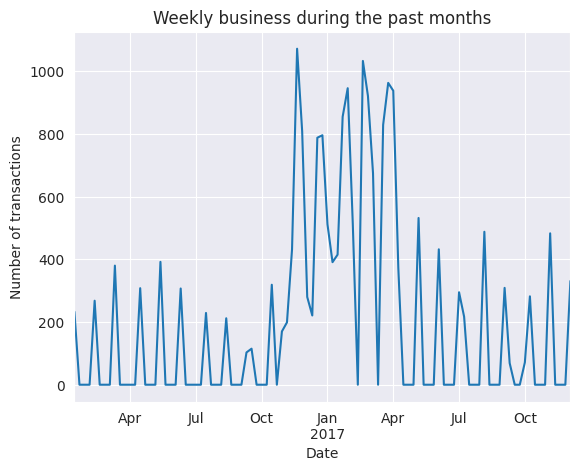

In [25]:
data['Item'].resample('W').count().plot()
plt.ylabel('Number of transactions')
plt.title('Weekly business during the past months')

This plot shows the weekly performance of the bakery.


Text(0.5, 1.0, 'Daily business during the past months')

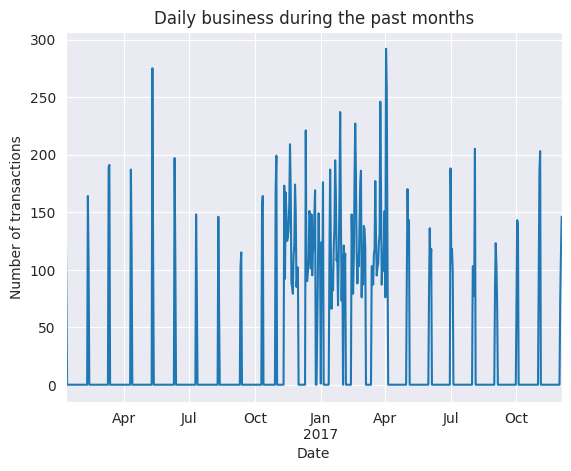

In [26]:
data['Item'].resample('D').count().plot()
plt.ylabel('Number of transactions')
plt.title('Daily business during the past months')

I analyzed the daily performance of the bakery and found that there have been some days when the bakery even sold 0 items suggesting that,perhaps, the bakery might not be as well-established or prominently identified by customers.

In [27]:
data['Item'].resample('D').count().min()

0

In [28]:
data['Item'].resample('D').count().max()

292

During the most profitable day the bakery could sell around 292 items and this happened in April (as visible in the daily graph above).

## #Apriori Algorithm and Association Rule Analysis:

Next, I conducted association rule analysis to understand how items are related to one another within the dataset. Association rule analysis is used to determine interesting relationships and patterns between items in transactions. The primary metrics used to measure these associations are:

**Support:** This metric quantifies the frequency or prevalence of an item within the dataset. It can be broken down into three types:

**Antecedent Support:** The proportion of transactions containing the antecedent item.
**Consequent Support:** The proportion of transactions containing the consequent item.
**Support:** The proportion of transactions containing both the antecedent and consequent items.
**Confidence:** This metric represents the probability that the consequent item will appear in a transaction given that the antecedent item is present. It measures the strength of the association between the items.

**Lift:** This metric evaluates the likelihood of the antecedent and consequent items being purchased together compared to their independent probabilities. A lift value greater than 1 indicates that the items are more likely to be bought together than would be expected by chance.

**Leverage:** This metric measures the difference between the observed frequency of the antecedent and consequent items appearing together and the frequency expected if they were independent. It provides insight into how much more often the items are purchased together compared to if they were unrelated.

**Conviction:** This metric assesses how strongly the presence of the antecedent item implies the presence of the consequent item. A higher conviction score indicates a stronger dependency of the consequent on the antecedent.

The Apriori algorithm is employed to identify frequent itemsets, which are then used to perform association rule analysis. In this algorithm, users set a minimum support threshold, which determines whether an itemset is considered frequent based on its occurrence in the dataset.

To start with the association rule analysis, I created a dataset that lists items frequently bought together

In [29]:
lst=[]
for item in data['Transaction'].unique():
    lst2=list(set(data[data['Transaction']==item]['Item']))
    if len(lst2)>0:
        lst.append(lst2)
print(lst[0:3])
print(len(lst))

[['Bread'], ['Scandinavian'], ['Hot chocolate', 'Cookies', 'Jam']]
9465


To apply the Apriori algorithm, the dataset must first be one-hot encoded. This is achieved using the TransactionEncoder, as shown here. Once the data is one-hot encoded, the Apriori algorithm can be used to identify frequent itemsets. After obtaining these itemsets, the association_rules function is employed to generate the association rules. For this analysis, I used the 'lift' criterion and set a minimum threshold of 1.


In [30]:
te=TransactionEncoder()
te_data=te.fit(lst).transform(lst)
data_x=pd.DataFrame(te_data,columns=te.columns_)
print(data_x.head())

frequent_items= apriori(data_x, use_colnames=True, min_support=0.03)
print(frequent_items.head())

rules = association_rules(frequent_items, metric="lift", min_threshold=1)
rules.antecedents = rules.antecedents.apply(lambda x: next(iter(x)))
rules.consequents = rules.consequents.apply(lambda x: next(iter(x)))
rules

   Adjustment  Afternoon with the baker  Alfajores  Argentina Night  Art Tray  \
0       False                     False      False            False     False   
1       False                     False      False            False     False   
2       False                     False      False            False     False   
3       False                     False      False            False     False   
4       False                     False      False            False     False   

   Bacon  Baguette  Bakewell  Bare Popcorn  Basket  ...  The BART  The Nomad  \
0  False     False     False         False   False  ...     False      False   
1  False     False     False         False   False  ...     False      False   
2  False     False     False         False   False  ...     False      False   
3  False     False     False         False   False  ...     False      False   
4  False     False     False         False   False  ...     False      False   

   Tiffin  Toast  Truffles  Tshi

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,Cake,Coffee,0.103856,0.478394,0.054728,0.526958,1.101515,0.005044,1.102664,0.102840
1,Coffee,Cake,0.478394,0.103856,0.054728,0.114399,1.101515,0.005044,1.011905,0.176684
2,Coffee,Medialuna,0.478394,0.061807,0.035182,0.073542,1.189878,0.005614,1.012667,0.305936
3,Medialuna,Coffee,0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871,0.170091
4,Coffee,Pastry,0.478394,0.086107,0.047544,0.099382,1.154168,0.006351,1.014740,0.256084
5,Pastry,Coffee,0.086107,0.478394,0.047544,0.552147,1.154168,0.006351,1.164682,0.146161
6,Coffee,Sandwich,0.478394,0.071844,0.038246,0.079947,1.112792,0.003877,1.008807,0.194321
7,Sandwich,Coffee,0.071844,0.478394,0.038246,0.532353,1.112792,0.003877,1.115384,0.109205


Next, NetworkX was utilized, a Python package for creating and analyzing complex networks, to build a network graph that visualizes the associations between antecedents and consequents derived from the association rules. The graph reveals that coffee is a highly popular item frequently paired with pastries, cakes, medialunas, and sandwiches sold at the bakery. This indicates that if a customer buys any of these four items, they are likely to purchase coffee as well. Conversely, if a customer buys coffee, they are also likely to buy one of the four items.






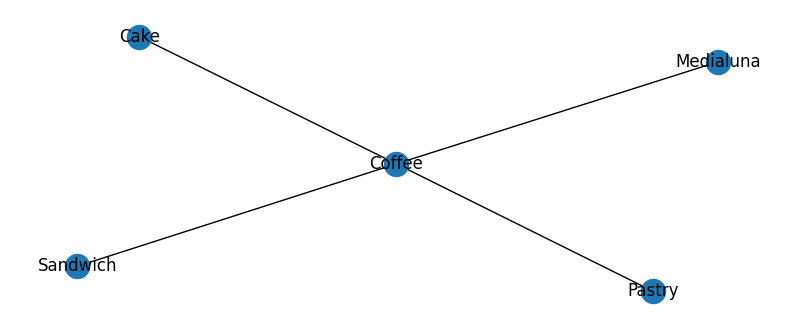

In [31]:
fig, ax=plt.subplots(figsize=(10,4))
GA=nx.from_pandas_edgelist(rules,source='antecedents',target='consequents')
nx.draw(GA,with_labels=True)
plt.show()

## #Conclusion

**Coffee is the bestseller of this bakery and it shows association with 4 items- pastry, cake, medialuna and sandwich. There are a couple of strategies that the bakery can adopt to increase its sales considering the association we have seen between coffee and its 4 partners.**

**Promotional discount in either one of the 4 partners can entice customers to buy coffee. This will also work the other way around.**

**Placing these 4 items close to coffee ordering counter can be a good strategy to attract customers in buying these, a common practice which can be observed in many bakeries and coffee shops alreay. This highlights the importance of data analysis and insights adopted by cafe owners to boost sales of items.**

**Another unique idea could be proposing some recipes like a coffee cake or coffee pastry. That would probably entice coffee and cake/pastry lovers.**

**Yet another suggestion is a loyalty program where customers earn points for each coffee purchase that can be redeemed for free or discounted pastries, cakes, medialunas, or sandwiches.**

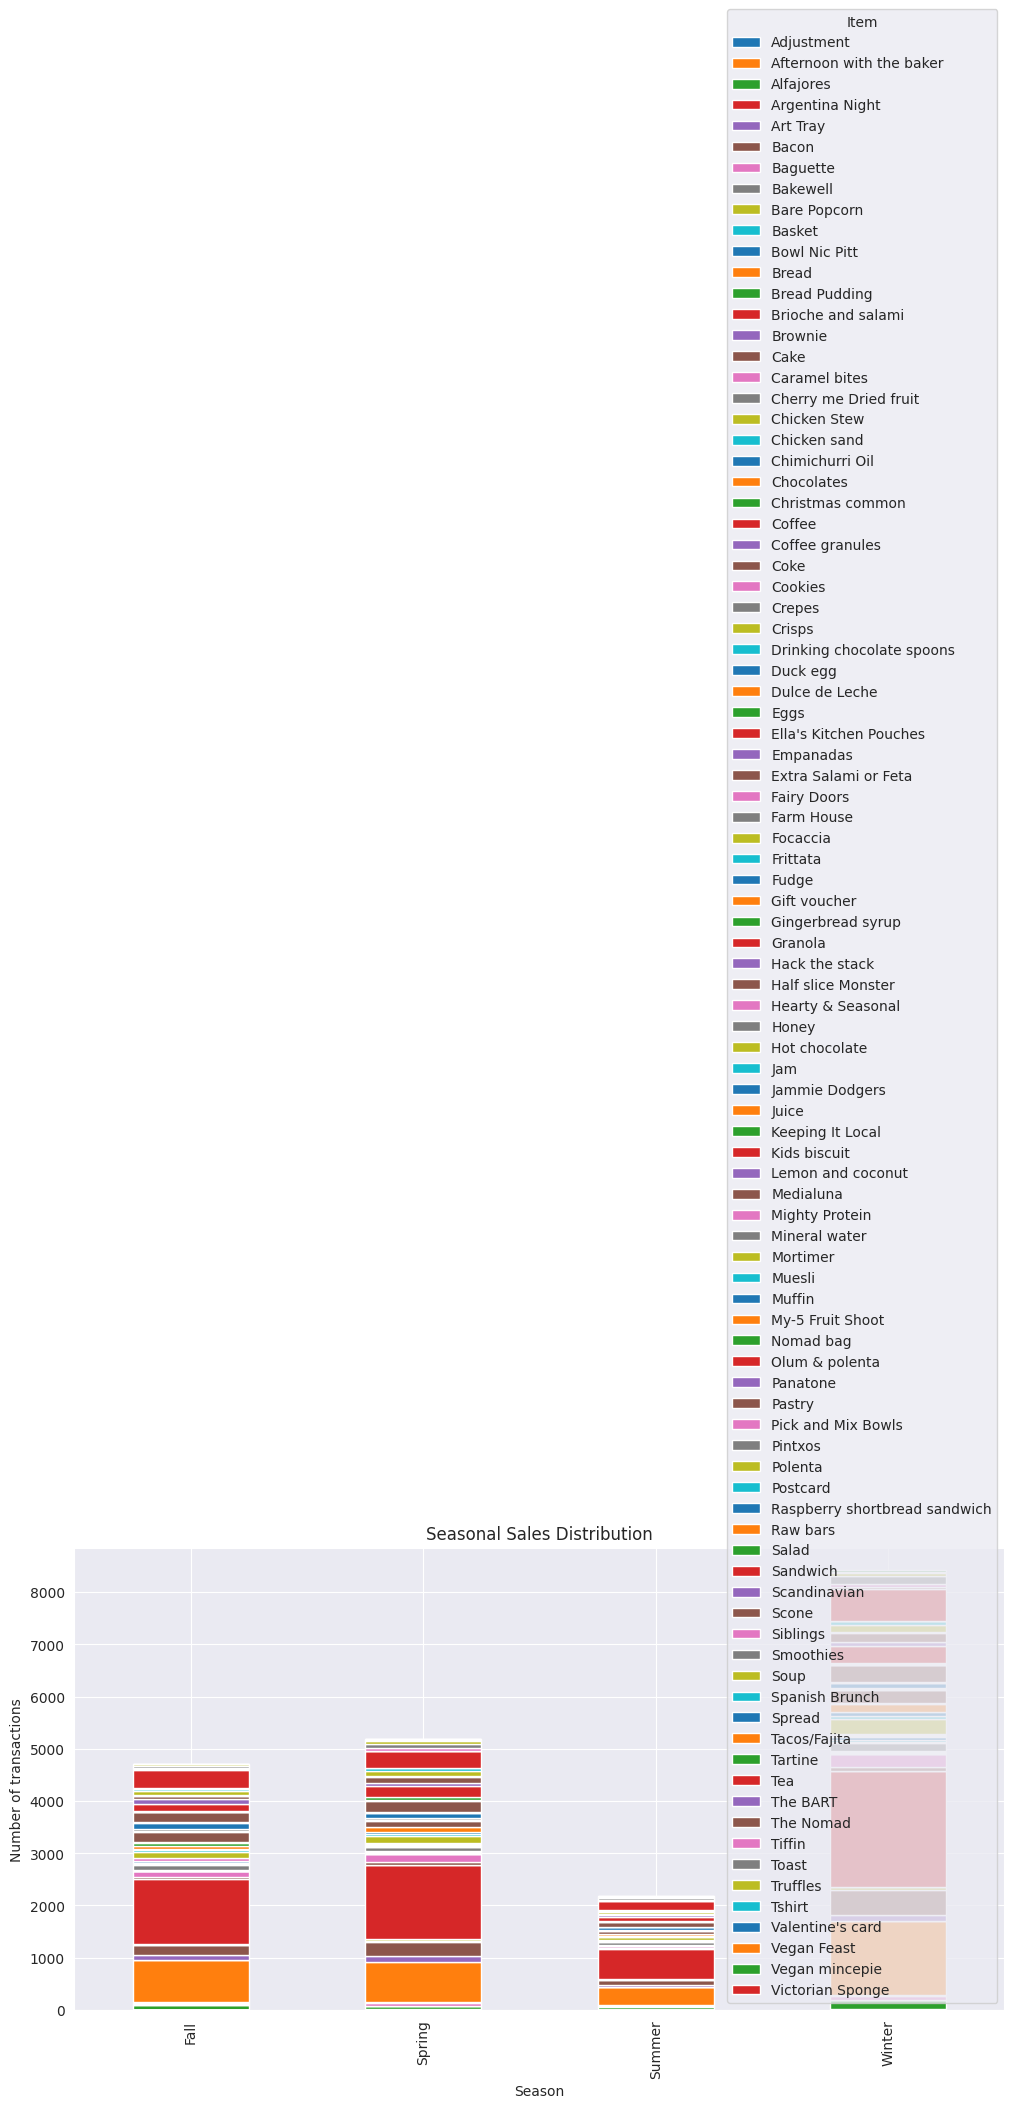

In [32]:

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

data['Season'] = data['Month'].apply(get_season)

seasonal_sales = data.groupby(['Season', 'Item']).size().unstack().fillna(0)
seasonal_sales.plot(kind='bar', stacked=True, figsize=(12,6))
plt.ylabel('Number of transactions')
plt.title('Seasonal Sales Distribution')
plt.show()


Moving forward, I tried to see if I could gain some more insights from the data. Here, I have tried to find out if there are any seasonal trends in the sales data for all items.

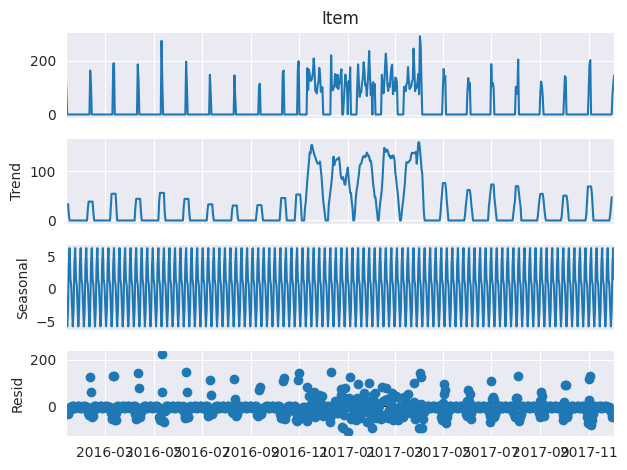

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Aggregate sales data by day
daily_sales = data['Item'].resample('D').count()

# Decompose time series
result = seasonal_decompose(daily_sales, model='additive')
result.plot()
plt.show()

Here, I tried to decompose the time series data into trend, seasonality, and residuals to identify underlying patterns.



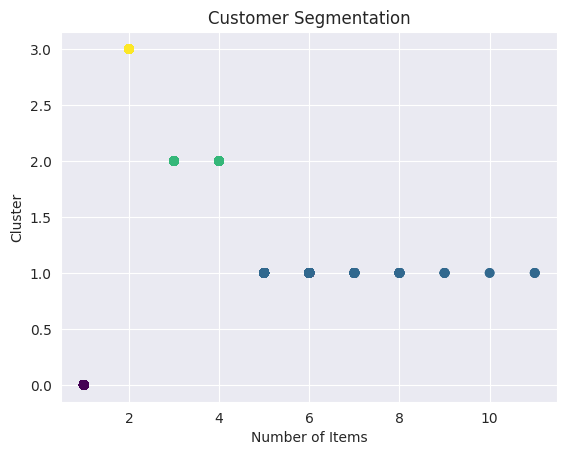

In [34]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Aggregate data by customer
customer_data = data.groupby('Transaction')['Item'].count().reset_index()
customer_data.rename(columns={'Item': 'Num_Items'}, inplace=True)

# Scale features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data[['Num_Items']])

# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=0).fit(scaled_data)
customer_data['Cluster'] = kmeans.labels_

# Plot clusters
plt.scatter(customer_data['Num_Items'], customer_data['Cluster'], c=customer_data['Cluster'], cmap='viridis')
plt.xlabel('Number of Items')
plt.ylabel('Cluster')
plt.title('Customer Segmentation')
plt.show()


Over here, as an attempt for customer segmentation, I tried to cluster customers based on their purchasing behavior to identify different segments.

13:41:38 - cmdstanpy - INFO - Chain [1] start processing
13:41:39 - cmdstanpy - INFO - Chain [1] done processing


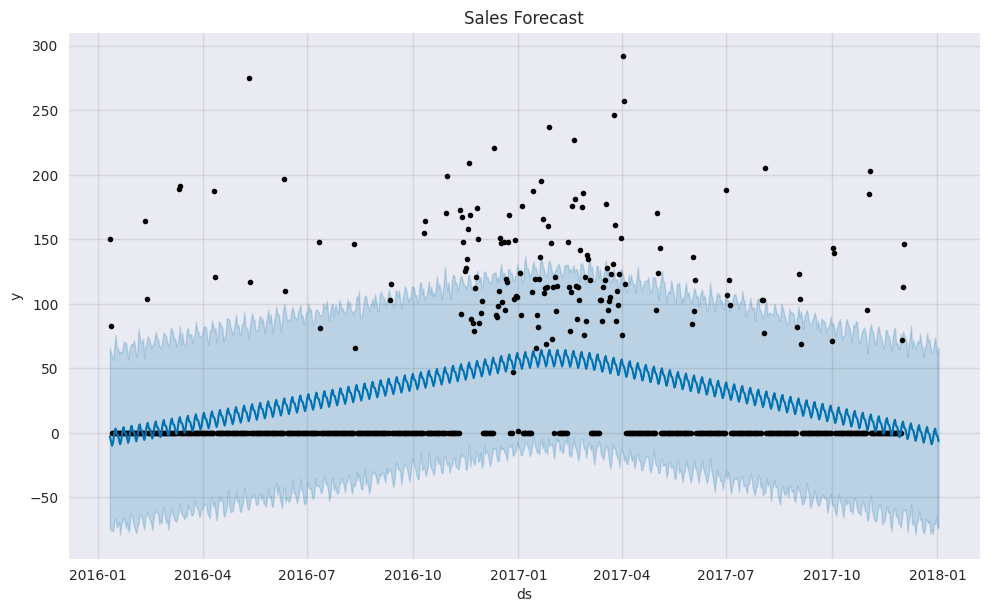

In [36]:
from prophet import Prophet

# Prepare data for Prophet
prophet_data = daily_sales.reset_index().rename(columns={'Item': 'y', 'Date': 'ds'})

# Initialize and fit Prophet model
model = Prophet()
model.fit(prophet_data)

# Create future dataframe and forecast
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.title('Sales Forecast')
plt.show()


Here, I have used a time series forecasting method called Prophet to predict future sales.

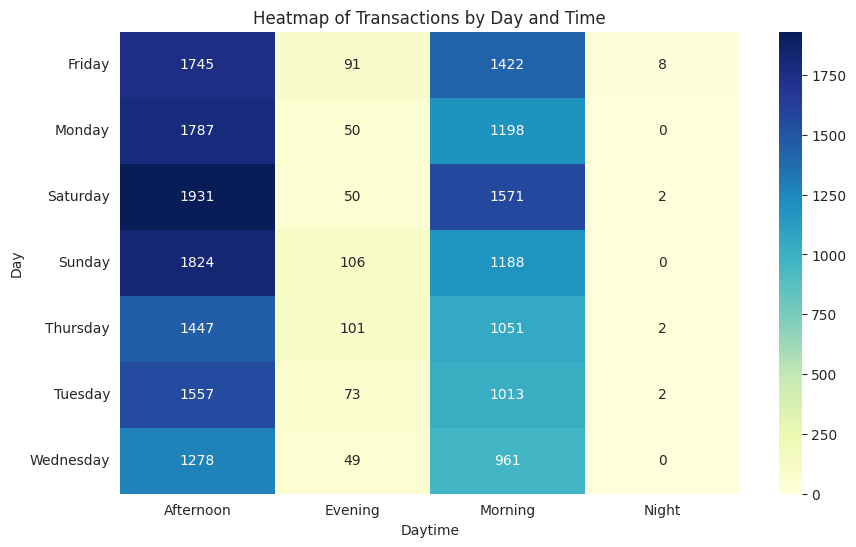

In [37]:
# Create a pivot table for heatmap
heatmap_data = data.pivot_table(index='Day', columns='Daytime', aggfunc='size', fill_value=0)

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Heatmap of Transactions by Day and Time')
plt.show()


Here, I have created heatmaps to visualize transactions by day of the week and time of the day.



## # Final Note 

Through extensive analysis of the bakery sales data, several methods, algorithms, and concepts have been employed to gain valuable insights and enhance our understanding of the business. The following approaches were utilized:

Initial steps involved cleaning the dataset and restructuring the data for better analysis.

Using Descriptive Analytics, various visualizations, including bar charts and time series plots, were created to explore item popularity, daily and monthly sales patterns, and business performance trends. These visualizations helped identify key trends and peak business periods.

By utilizing Time-Based Analysis, the data was segmented into different parts of the day (Morning, Afternoon, Evening, Night) to analyze sales patterns throughout the day. Additionally, time series decomposition was used to understand trends and seasonality in daily sales data.

Association Rule Mining: The Apriori algorithm was applied to identify frequent itemsets and generate association rules. This helped reveal significant associations between coffee and other products like pastries, cakes, medialunas, and sandwiches. The mlxtend library was used for implementing these algorithms.

Then, the Associations were visualized. Network graphs were created using NetworkX to visualize the relationships between items based on association rules. This visualization provided a clear picture of how different items are connected through customer purchases.

Prophet tool was employed to predict future sales trends, help plan for demand fluctuations, and perform time series forecasting.

Additional pivot tables and clustering techniques were used to uncover patterns in sales data and customer behavior. For instance, KMeans clustering was used to segment customers based on their purchasing behavior.

Various strategies, including seasonal promotions and custom bundling, were suggested based on the observed associations and sales trends.
